# 1 Entendimiento de datos/negocio

**Context:** 

FutAlpes F.C., a club in one of Europe’s top five leagues, aims to strengthen its squad in the 2025 transfer market. The club has a budget of €100M and wants to sign 1 player per zone (goalkeeper, defender, midfielder, forward). The transfer market is highly competitive, with historically high player prices.

**Current Problem:**

Player valuations are often based on intuition or experience of agents and scouts. This creates uncertainty and financial risk in investments.

**Proposal:**

Build a machine learning model to predict a player’s market value based on performance statistics.
Include both traditional metrics (goals, assists, passes, duels) and advanced ones (xG, npxG, xA, PSxG).
Assess data quality and representativeness to ensure a solid foundation for the model.

**Expected Value:**
- Reduce uncertainty in transfer negotiations.
- Identify players offering the best performance-to-price ratio.
- Maximize return on investment while reinforcing the squad within budget.

⚠️ Usar <=Python3.11

## 1.1 Carga de datos

In [242]:
import numpy as np
import pandas as pd
import re

%matplotlib inline


In [209]:
db_location = 'data/datos_entrenamiento_laboratorio1(train_data).csv'

In [210]:
football_df=pd.read_csv(db_location, sep=',', encoding = "UTF-8-SIG")

In [211]:
football_df.shape

(57934, 50)

### 1.1.1 Eliminación de columnas duplicadas

Las siguientes columnas estaban duplicadas entonces las eliminamos del dataframe.

In [271]:
dupe_cols = [
    "xAG.1",
    "Pases_intentados.1",
    "Pases_intentados.2",
    "Pases_progresivos.1",
    "Regates_exitosos.1",
    "xAG.2",
    "xAG.3",
    "Pases_completados.1",
    "Pases_completados.2",
]

football_df_slim = football_df.drop(columns=dupe_cols, errors="raise")
football_df_slim.shape

(57934, 41)

In [213]:
print(football_df_slim.sample(10).to_string())

                     Jugador Nacionalidad Posicion    Edad                Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date
47999  Ainsley MaitlandNiles      eng ENG       WB  27-001     Friday August 30, 2024      1              2  0.3   0.3  0.2                         3                39                  5                 1                         9                 

### 1.1.2 Analisis de tipos de datos

In [ ]:
!pip install ydata-profiling
!pip install ipywidgets

In [ ]:
# import pandas_profiling

# profiling = pandas_profiling.ProfileReport(football_df_slim)
# profiling.to_file("football_profile.html")

In [187]:
football_df_slim.dtypes

Jugador                            object
Nacionalidad                       object
Posicion                           object
Edad                               object
Dia_partido                        object
Goles                               int64
Tiros Totales                       int64
xG                                float64
npxG                              float64
xAG                               float64
Acciones_que_crean_tiros            int64
Pases_intentados                    int64
Pases_progresivos                   int64
Regates_exitosos                    int64
Pases_medios_completados            int64
Pases_largos_completados            int64
xA                                float64
Pases_en_ultimo_tercio              int64
Pases_balon_vivo                    int64
Pases_balon_muerto                  int64
Pases_al_hueco                      int64
Pases_centros                       int64
Pases_completados                   int64
Pases_fuera_de_juego              

In [214]:
# Analisis de la variable "Jugador"
num_players = football_df_slim["Jugador"].nunique()
print("Total distinct players:", num_players)

Total distinct players: 2242


In [51]:
# Fuzzy search para encontrar nombres parecidos
!pip install rapidfuzz
from rapidfuzz import fuzz

unique_names = football_df["Jugador"].unique()

possible_dupes = []
for i, name in enumerate(unique_names):
    for other in unique_names[i+1:]:
        score = fuzz.ratio(name, other)
        if score > 88.5:  
            possible_dupes.append((name, other, score))

for name1, name2, score in possible_dupes:
    print(f"{name1}  <--->  {name2}   (similarity: {score}%)")

Neco Williams  <--->  Nico Williams   (similarity: 92.3076923076923%)
Valentin Rosier  <--->  Valentin Rongier   (similarity: 90.32258064516128%)
Sergio Gomez  <--->  Sergi Gomez   (similarity: 95.65217391304348%)
Dani Rodriguez  <--->  Daniel Rodriguez   (similarity: 93.33333333333333%)
Pablo Marin  <--->  Pablo Mari   (similarity: 95.23809523809523%)
Jon Martin  <--->  Jonas Martin   (similarity: 90.9090909090909%)
Ismael Konate  <--->  Ismael Kone   (similarity: 91.66666666666666%)


In [180]:
# Analisis de la variable "Nacionalidad"
print(football_df_slim["Nacionalidad"].value_counts().to_string())

Nacionalidad
es ESP     8806
fr FRA     5684
it ITA     4400
eng ENG    4027
br BRA     1851
ar ARG     1613
pt POR     1313
nl NED     1261
ci CIV      903
be BEL      825
sn SEN      820
ma MAR      810
dk DEN      726
se SWE      664
ng NGA      592
hr CRO      535
rs SRB      534
de GER      533
gh GHA      507
ch SUI      498
co COL      462
no NOR      452
uy URU      443
cm CMR      441
pl POL      425
sct SCO     423
ml MLI      406
jp JPN      401
us USA      370
dz ALG      368
ie IRL      318
wls WAL     226
al ALB      219
ua UKR      217
ca CAN      202
tr TUR      192
ro ROU      189
sk SVK      188
gn GUI      174
ao ANG      174
ge GEO      164
at AUT      154
hu HUN      147
eg EGY      145
gr GRE      144
cd COD      143
ec ECU      140
is ISL      140
cz CZE      140
si SVN      135
py PAR      129
mx MEX      128
xk KVX      124
ve VEN      117
ga GAB       94
tn TUN       88
kr KOR       87
jm JAM       84
cl CHI       83
nz NZL       82
me MNE       78
cg CGO     

In [53]:
# Analisis de la variable "Posicion"
print(football_df_slim["Posicion"].value_counts().to_string())

Posicion
CB                9537
FW                6858
CM                5763
GK                3987
DM                3729
RB                3265
LB                3244
AM                3236
LW                2703
RW                2638
WB                1903
LM                1654
RM                1629
DM,CM              529
CM,DM              376
LW,RW              221
AM,FW              211
FW,AM              190
LW,LM              175
RW,LW              160
AM,CM              157
RW,RM              147
RB,CB              141
LM,CM              131
AM,LW              128
CB,RB              127
LW,AM              125
FW,LW              118
RM,CM              118
RW,FW              115
LW,FW              115
CM,RM              112
AM,DM              111
CM,AM              109
FW,RW              108
WB,LB              107
CM,LM              105
RM,RW              105
AM,RW              103
RM,LM              102
LM,RM               98
DM,AM               95
CB,LB               92
WB

In [54]:
# Analisis de variable "Edad" (e.g 20-034, 24-122)
mask = football_df_slim["Edad"].astype(str).str.startswith("20")
subset = football_df_slim.loc[mask, "Edad"]

suffix = subset.str.split("-").str[1].astype(int)
print("Min suffix:", suffix.min())
print("Max suffix:", suffix.max())

Min suffix: 0
Max suffix: 365


In [55]:
# Analisis de variable "Goles"
goles = football_df_slim["Goles"]
print("Min goles:", goles.min())
print("Max goles:", goles.max())

goles.value_counts()
football_df_slim = football_df_slim.sort_values(by="Goles", ascending=False)
print(
    football_df_slim.loc[
        football_df_slim["Goles"] > 5, ["Jugador", "Goles"]
    ].to_string()
)

Min goles: -5
Max goles: 995
                     Jugador  Goles
27143          Sergi Roberto    995
42430          Jaydee Canvot    955
33118     Henrikh Mkhitaryan    910
45061            Desire Doue    887
7706           Neco Williams    871
32240              Saul Coco    862
37399        Amir Richardson    861
36984         Pietro Comuzzo    838
4086         Nicolas Jackson    807
26484         Stefan de Vrij    795
41484           Steve Ngoura    792
12403        Victor Meseguer    689
19962             Kike Salas    663
54110              Junya Ito    663
27555              Isak Hien    663
53488        Lilian Raolisoa    633
47821        Abdoulaye Toure    632
18111        Jorge de Frutos    594
36477     Rolando Mandragora    590
16916  Isaac Palazon Camacho    557
52808        Jonathan Gradit    537
4948          Bernardo Silva    528
10901       Antonee Robinson    509
26396         Marten de Roon    507
5784                   Andre    505
1856                Casemiro    485

In [56]:
# Analisis de variable "Tiros totales"
tiros_totales = football_df_slim["Tiros Totales"]
print("Min Tiros Totales:", tiros_totales.min())
print("Max Tiros Totales:", tiros_totales.max())
print("Mean Tiros Totales:", tiros_totales.mean())

Min Tiros Totales: 0
Max Tiros Totales: 12
Mean Tiros Totales: 0.7924016984844824


In [57]:
# Analisis de variable "xG"
xG = football_df_slim["xG"]
print("Min xG:", xG.min())
print("Max xG:", xG.max())
print("Mean xG:", xG.mean())

Min xG: 0.0
Max xG: 2.9
Mean xG: 0.08863534366693135


In [58]:
# Analisis de variable "market_value"
# See how many distinct market values each player has
# Group and collect the unique values as a Python list
market_values_per_player = (
    football_df_slim.groupby("Jugador")["market_value"]
    .apply(lambda x: list(set(x)))
    .reset_index()
)

print(market_values_per_player.to_string())

                             Jugador                      market_value
0              Aaron Ciammaglichella                           [€700k]
1                    Aaron Cresswell                             [nan]
2                      Aaron Malouda                             [nan]
3                       Aaron Martin                          [€6.50m]
4                     Aaron Ramsdale                [€16.00m, €10.00m]
5                   Aaron WanBissaka                         [€24.00m]
6                       Abakar Sylla                         [€10.00m]
7                      Abdallah Sima                          [€9.00m]
8                    Abde Ezzalzouli                         [€12.00m]
9                        Abdel Abqar                          [€7.50m]
10               Abderrahman Rebbach                           [€700k]
11                       Abdon Prats                          [€1.20m]
12                     Abdou Harroui                          [€1.80m]
13    

In [59]:

total_players_multiple_mv = (
    football_df.groupby("Jugador")["market_value"]
    .nunique()
    .gt(1)  # True if >1
    .sum()  # count how many True
)

print(f"# de jugadores con más de un market value: {total_players_multiple_mv}")

# de jugadores con más de un market value: 174


Teniendo en cuenta los valores y los tipos de datos del dataframe, hallamos estas observaciones en el esquema de datos:
- **Jugador** se representa como ```object``` ("Bruno Fernandes") pero debería ser de tipo ```StringDtype``` ya que es texto puro. (Algunos de estos nombres podrían representar el mismo jugador pero con errores)

- **Nacionalidad** se representa como ```object``` ("eng ENG") pero debería ser de tipo ```StringDtype``` ya que es texto puro pero toca transformarlo para que solo sea "ENG".

- **Posicion** se representa como ```object``` ("DM,AM") pero debería ser transformado en algún tipo de encoder ya que cada jugador puede tener mas de una posición en un mismo partido. (Un candidato puede ser *One-Hot Encoding* de posiciones por partido para luego trasformarlo en datos más significativos).

- **Edad** se representa como ```object``` ("33-209") bajo la nomenclatura de "años-días" para cada partido. Debe ser consolidada en una sola edad tomando la edad máxima en el data set y convietiendola a ```float32```.

- **Dia_partido** se representa como ```object``` ("Friday August 16, 2024") pero debería ser de tipo ```Timestamp```.

- **market_value** se representa como ```object``` ("€50.00m") pero debería ser de tipo ```float32```. Esta variable tiene 174 jugadores que tienen más de un **market_value**. Sin embargo, hay ~2000 jugadores unicos lo cual indica que esta variable debería guardar el valor más reciente en el tiempo para cada jugador.

- **contract_date** se representa como ```object``` ("30.06.2028") pero debería ser de tipo ```Timestamp```.


## 1.2 Consideraciones de negocio

(Aca van descripciones de temas relevantes al negocio)

# 2. Preparación de datos

In [272]:
print(football_df_slim.head(10).to_string())

              Jugador Nacionalidad Posicion    Edad             Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date
0     Bruno Fernandes       pt POR    FW,AM  29-343  Friday August 16, 2024      0              6  1.2   1.2  0.0                         2                60                  6                 1                        14                         4  0.0      

## 2.1 Eliminación de filas duplicadas (Pt 1)
Ahora, queremos eliminar los registros de jugadores con valores identicos. Estos son duplicados inecesarios.

In [249]:
# 1. Ver cantidad de jugadores únicos
print("Jugadores distintos:", football_df_slim["Jugador"].nunique())

Jugadores distintos: 2242


Anteriormente vimos que estos jugadores tenian similitud > 88.5% en el nombre

```
Neco Williams  <--->  Nico Williams   (similarity: 92.3076923076923%)
Valentin Rosier  <--->  Valentin Rongier   (similarity: 90.32258064516128%)
Sergio Gomez  <--->  Sergi Gomez   (similarity: 95.65217391304348%)
Dani Rodriguez  <--->  Daniel Rodriguez   (similarity: 93.33333333333333%)
Pablo Marin  <--->  Pablo Mari   (similarity: 95.23809523809523%)
Jon Martin  <--->  Jonas Martin   (similarity: 90.9090909090909%)
Ismael Konate  <--->  Ismael Kone   (similarity: 91.66666666666666%)
```


In [273]:
pairs = [
    ("Neco Williams", "Nico Williams"),
    ("Valentin Rosier", "Valentin Rongier"),
    ("Sergio Gomez", "Sergi Gomez"),
    ("Dani Rodriguez", "Daniel Rodriguez"),
    ("Pablo Marin", "Pablo Mari"),
    ("Jon Martin", "Jonas Martin"),
    ("Ismael Konate", "Ismael Kone"),
]

for p1, p2 in pairs:
    print(f"\n=== {p1}  <->  {p2} ===")
    subset = football_df_slim[
        football_df_slim["Jugador"].str.lower().isin([p1.lower(), p2.lower()])
    ][["Jugador", "Edad", "Nacionalidad"]]

    print(subset.drop_duplicates().sort_values("Jugador").to_string(index=False))


=== Neco Williams  <->  Nico Williams ===
      Jugador   Edad Nacionalidad
Neco Williams 23-126      wls WAL
Neco Williams 23-294      wls WAL
Neco Williams 23-308      wls WAL
Neco Williams 23-316      wls WAL
Neco Williams 23-319      wls WAL
Neco Williams 23-329      wls WAL
Neco Williams 23-336      wls WAL
Neco Williams 23-287      wls WAL
Neco Williams 23-353      wls WAL
Neco Williams 23-364      wls WAL
Neco Williams 24-008      wls WAL
Neco Williams 24-018      wls WAL
Neco Williams 24-028      wls WAL
Neco Williams 24-035      wls WAL
Neco Williams 24-042      wls WAL
Neco Williams 23-357      wls WAL
Neco Williams 23-281      wls WAL
Neco Williams 24-022      wls WAL
Neco Williams 23-268      wls WAL
Neco Williams 23-276      wls WAL
Neco Williams 23-133      wls WAL
Neco Williams 23-140      wls WAL
Neco Williams 23-162      wls WAL
Neco Williams 23-168      wls WAL
Neco Williams 23-176      wls WAL
Neco Williams 23-191      wls WAL
Neco Williams 23-154      wls WAL
Neco 

Después de hacer validaciones comparando edad y nacionalidad con ayuda de un motro de busqueda, se puede verificar que ningún jugador está realmente presente bajo dos nombres diferentes. Sin embargo, hay un jugador "Dani Rodriguez" que solo tiene un registro en el dataset. Se puede considerar eliminar.

In [274]:
# True duplicates: entire row identical
true_dupes = football_df_slim[football_df_slim.duplicated(keep=False)]

print("Numero de true duplicates:", true_dupes.shape[0])

Numero de true duplicates: 20966


In [275]:
before = football_df_slim.shape[0]
football_df_slim = football_df_slim.drop_duplicates(keep="first")
after = football_df_slim.shape[0]

print(f"Filas antes: {before}\nFilas después: {after}\nFilas eliminadas: {before - after}")

Filas antes: 57934
Filas después: 47451
Filas eliminadas: 10483


Después de eliminar las filas perfectamente duplicadas, ahora identificamos filas en las que el jugador tiene dos o mas registros en la misma fecha.

In [253]:
# Filtrar duplicados por Jugador + Dia_partido
dupes = football_df_slim[
    football_df_slim.duplicated(subset=["Jugador", "Dia_partido"], keep=False)
]

# Ordenar por jugador y fecha
dupes = dupes.sort_values(["Jugador", "Dia_partido"]).reset_index(drop=True)

print(f"Total de duplicados en Jugador y Dia_partido: {len(dupes)}")

Total de duplicados en Jugador y Dia_partido: 5229


Al mirar los datos, nos dimos cuenta que entre estas 5229 filas que comparted el mismo **Jugador** y **Dia_partido**, hay algunos que son identicos excepto por el valor de **Market_value**. El siguiente snippet busca los duplicados excluyendo la columna **Market_value**:

In [254]:
# Subset of columns to check (exclude market_value)
cols_to_check = [c for c in football_df_slim.columns if c != "market_value"]

# From your subset of dupes (same Jugador+Dia_partido)
exact_dupes_ignoring_mv = dupes[dupes.duplicated(subset=cols_to_check, keep=False)]

print("Duplicados exactos ignorando market_value:", exact_dupes_ignoring_mv.shape[0])

Duplicados exactos ignorando market_value: 1430


In [255]:
# Sacar jugadores y conflictos de market_value
multi_values = exact_dupes_ignoring_mv.groupby(["Jugador", "Dia_partido"])[
    "market_value"
].nunique()
# Each (Jugador, Dia_partido) with more than 1 unique value
conflicts = multi_values[multi_values > 1]

# Total number of conflicting values (all market_value entries in those dates)
total_conflicts = (
    exact_dupes_ignoring_mv.set_index(["Jugador", "Dia_partido"])
    .loc[conflicts.index]  # select only the conflicted (Jugador, Dia_partido)
    .shape[0]
)

# Number of "removable" rows (beyond the 1 you'd keep per date)
removable_rows = total_conflicts - len(conflicts)

print("Total conflicting rows:", total_conflicts)
print("Of which (to remove):", removable_rows)

Total conflicting rows: 1430
Of which (to remove): 735


Para eliminar estas filas duplicadas en **Jugador** y **Dia_partido**,toca preservar la fila con mayor valor de mercado para tener el más alto en esa fecha siendo optimistas. Sin embargo, para lograr esto toca limpiar el formato de los datos de **market_value** para que sea un número en millones de euros.

## 2.2 Transformación de datos en **market_value**

In [256]:
# Explorar formato de datos
distinct_market_values_raw = football_df_slim["market_value"].unique()

print("Distinct market values (raw):")
print(distinct_market_values_raw)

Distinct market values (raw):
['€50.00m' '-' '€1000.00m' '€45.00m' '€28.00m' '€30.00m' '€10.00m'
 '€40.00m' '€13.00m' nan '€25.00m' '€38.00m' '€1.00m' '€20.00m' '€5.00m'
 '€9.00m' '€15.00m' '€1.50m' '€14.00m' '€18.00m' '€6.00m' '€35.00m'
 '€22.00m' '€6.50m' '€70.00m' '€80.00m' '€100.00m' '€75.00m' '€23.00m'
 '€60.00m' '€120.00m' '€65.00m' '€16.00m' '€2.00m' '€32.00m' '€7.00m'
 '€8.00m' '€4.00m' '€300k' '€24.00m' '€11.00m' '€42.00m' '€12.00m'
 '€55.00m' '€750k' '€150.00m' '€85.00m' '€17.00m' '€27.00m' '€90.00m'
 '€180.00m' '€100k' '€200k' '€400k' '€800k' '€4.50m' '€500k' '€600k'
 '€110.00m' '€700k' 'error' '€350k' '€9999.99m' '€3.00m' '€2.50m' '€450k'
 '€1.40m' '€900k' '€3.50m' '€1.20m' '€1.80m' '€1.60m' '€7.50m' '€2.20m'
 '€140.00m' '€200.00m' '€170.00m' '€130.00m' '€2.80m' '€95.00m' '€26.00m'
 '€2.40m' '€8.50m' '€3.20m' '€5.50m' '€150k' '€3.40m' '€1.70m' '€250k'
 '€4.30m' '€3.60m' '€850k' '€1.30m' '€550k' '€650k' '€50k']


Al ver estos datos, podemos afirmar que filas con **market_value** de ```NaN```, ```-```, o ```error``` deben ser eliminadas ya que no van a poder contribuir al análisis de mercado.

In [276]:
# Eliminar filas con 'NaN', 'error', o '-' de market_value
football_df_slim_cleaned = football_df_slim[
    ~football_df_slim['market_value'].isin(['error', '-', np.nan])
]

print(f"Tamano original: {len(football_df_slim)}")
print(f"Tamano limpio: {len(football_df_slim_cleaned)}")
print(f"Filas eliminadas : {len(football_df_slim) - len(football_df_slim_cleaned)}")


Tamano original: 47451
Tamano limpio: 37234
Filas eliminadas : 10217


In [277]:
import numpy as np


# Function to clean market_value and convert to millions of euros
def clean_market_value(value):
    if isinstance(value, str):
        # Remove currency symbols and commas
        value = value.replace("€", "").replace(",", "").strip()

        # Handle 'k' for thousands (convert to millions)
        if "k" in value:
            return float(value.replace("k", "")) / 1000  # Convert to millions
        # Handle 'm' for millions
        elif "m" in value:
            return float(value.replace("m", ""))  # Already in millions
    try:
        # If it's already a number, return it in millions
        return float(value) / 1000000  # Convert to millions (if needed)
    except ValueError:
        # Return NaN if the value is invalid
        return np.nan


# Apply the cleaning function to the 'market_value' column using .loc to avoid the warning
football_df_slim_cleaned.loc[:, "market_value"] = football_df_slim_cleaned[
    "market_value"
].apply(clean_market_value)

# Now let's check how many rows were removed and how many are left
print(f"Original dataset size: {len(football_df_slim)}")
print(f"Cleaned dataset size : {len(football_df_slim_cleaned)}")
print(f"Rows removed         : {len(football_df_slim) - len(football_df_slim_cleaned)}")

Original dataset size: 47451
Cleaned dataset size : 37234
Rows removed         : 10217


Verificamos que la transformación se logró correctamente:

In [259]:
# Explorar formato de datos
distinct_market_values_raw = football_df_slim_cleaned["market_value"].unique()

print("Distinct market values (raw):")
print(distinct_market_values_raw)

Distinct market values (raw):
[50.0 1000.0 45.0 28.0 30.0 10.0 40.0 13.0 25.0 38.0 1.0 20.0 5.0 9.0 15.0
 1.5 14.0 18.0 6.0 35.0 22.0 6.5 70.0 80.0 100.0 75.0 23.0 60.0 120.0 65.0
 16.0 2.0 32.0 7.0 8.0 4.0 0.3 24.0 11.0 42.0 12.0 55.0 0.75 150.0 85.0
 17.0 27.0 90.0 180.0 0.1 0.2 0.4 0.8 4.5 0.5 0.6 110.0 0.7 0.35 9999.99
 3.0 2.5 0.45 1.4 0.9 3.5 1.2 1.8 1.6 7.5 2.2 140.0 200.0 170.0 130.0 2.8
 95.0 26.0 2.4 8.5 3.2 5.5 0.15 3.4 1.7 0.25 4.3 3.6 0.85 1.3 0.55 0.65
 0.05]


Aprovechamos para inspeccionar los outliers en market_value:

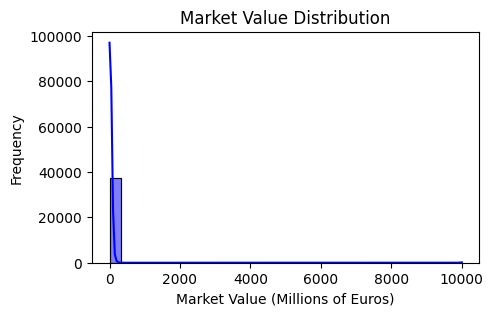

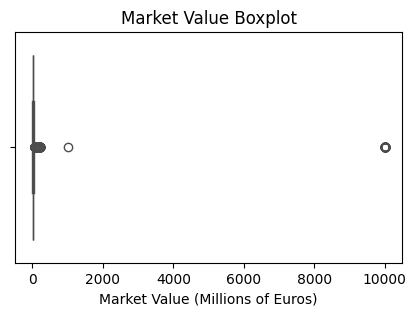

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# 1. Histogram
plt.figure(figsize=(5, 3))
sns.histplot(football_df_slim_cleaned["market_value"], kde=True, color="blue", bins=30)
plt.title("Market Value Distribution")
plt.xlabel("Market Value (Millions of Euros)")
plt.ylabel("Frequency")
plt.show()

# 2. Boxplot
plt.figure(figsize=(5, 3))
sns.boxplot(x=football_df_slim_cleaned["market_value"], color="orange")
plt.title("Market Value Boxplot")
plt.xlabel("Market Value (Millions of Euros)")
plt.show()




In [261]:
# Sort by market_value in descending order and get the top 20 players
top_100_players = (
    football_df_slim_cleaned[["Jugador", "market_value"]]
    .sort_values(by="market_value", ascending=False)
    .head(100)
)

# Display the top 20 players
print(top_100_players.to_string(index=False))

              Jugador market_value
        Dennis Appiah      9999.99
       Thomas Meunier      9999.99
         Benat Prados      9999.99
   Henrikh Mkhitaryan      9999.99
          Kyle Walker      9999.99
           Kike Salas      9999.99
      Brennan Johnson      9999.99
          Timo Werner      9999.99
        Lucas Paqueta      9999.99
      Jorge de Frutos      9999.99
         Obite NDicka      9999.99
          Desire Doue      9999.99
     Łukasz Skorupski      9999.99
       Pietro Comuzzo      9999.99
         Clinton Mata      9999.99
   Andrew Omobamidele      9999.99
Jose Luis Garcia Vaya      9999.99
       Nathan Collins      9999.99
         Falaye Sacko      9999.99
        Shavy Babicka      9999.99
        Daniel Vivian      9999.99
   Soumaila Coulibaly      9999.99
       NgalAyel Mukau      9999.99
     Antonee Robinson      9999.99
          John McGinn      9999.99
    Dylan Batubinsika      9999.99
         James Garner      9999.99
        Jaydee Canvo

Verificando en la página web de ```Transfermarkt```, el jugador más valioso del mundo es Lamine Yamal. Asi que todas las filas con **market_value** > 200M se descartan.

In [278]:
# borrar filas 
football_df_slim_cleaned = football_df_slim_cleaned[football_df_slim_cleaned['market_value'] <= 200.0]

# Confirm the size of the DataFrame after removal
print(f"Dataset size after deletion: {len(football_df_slim_cleaned)}")


Dataset size after deletion: 37182


Confirmamos que solo hay valores reales

In [279]:
# Agrupar por jugador y obtener el valor máximo de mercado para cada jugador
max_market_value_per_player = (
    football_df_slim_cleaned.groupby("Jugador")["market_value"].max().reset_index()
)

# Ordernar por valor de mercado en orden descendente para ver los jugadores con mayor valor de mercado
max_market_value_per_player_sorted = max_market_value_per_player.sort_values(
    by="market_value", ascending=False
)

print(max_market_value_per_player_sorted.head(10).to_string(index=False))

          Jugador market_value
     Lamine Yamal        200.0
  Jude Bellingham        180.0
   Erling Haaland        180.0
    Kylian Mbappe        180.0
  Vinicius Junior        170.0
      Bukayo Saka        150.0
            Pedri        140.0
Federico Valverde        130.0
      Declan Rice        120.0
      Cole Palmer        120.0


In [ ]:
print(football_df_slim.head(10).to_string())

## 2.3 Transformación de datos en **Dia_partido**

Las fechas en esta columna están así "Saturday October 19, 2024". Toca transformar a datetime.

In [287]:
# Get unique values in the 'Dia_partido' column
unique_dia_partido = football_df_slim_cleaned["Dia_partido"].unique()

# Print each unique 'Dia_partido' value on a new line
for date in unique_dia_partido:
    print(date)

Friday August 16, 2024
Saturday August 17, 2024
Sunday August 18, 2024
Monday August 19, 2024
Saturday August 24, 2024
Sunday August 25, 2024
Saturday August 31, 2024
Sunday September 1, 2024
Sunday September 1, 2024 North
Saturday September 14, 2024
Sunday September 15, 2024 North
Sunday September 15, 2024
Saturday September 21, 2024
Sunday September 22, 2024
Saturday September 28, 2024
Sunday September 29, 2024
Monday September 30, 2024
Saturday October 5, 2024
Sunday October 6, 2024
Saturday October 19, 2024
Sunday October 20, 2024
Monday October 21, 2024
Friday October 25, 2024
Saturday October 26, 2024
Sunday October 27, 2024
Saturday November 2, 2024
Sunday November 3, 2024
Monday November 4, 2024
Saturday November 9, 2024
Sunday November 10, 2024
Sunday November 10, 2024 North West
Saturday November 23, 2024
Sunday November 24, 2024
Monday November 25, 2024
Friday November 29, 2024
Saturday November 30, 2024
Sunday December 1, 2024
Tuesday December 3, 2024
Wednesday December 4, 

Algunas de las fechas tienen información adicional que sobra:

Por ejemplo:

```
Sunday January 5, 2025 North
Sunday September 1, 2024 North
Sunday February 2, 2025 Derby
Sunday September 22, 2024 Derby
Thursday February 6, 2025
Wednesday January 15, 2025
```

Ya con la columna **market_value** limpia, podemos eliminar los duplicados que comparted **Jugador** y **Dia_partido**:

Para poder eliminar estos duplicados, ordenamos el dataframe y asignamos ids unicos

In [294]:
# Clean the 'Dia_partido' column in the DataFrame
football_df_slim_cleaned["Dia_partido"] = football_df_slim_cleaned["Dia_partido"].apply(
    lambda x: re.sub(r"(\s.*\d{4})\s.*$", r"\1", x)  # Remove anything after the year
)

# Convert the cleaned 'Dia_partido' column to datetime format
football_df_slim_cleaned["Dia_partido"] = pd.to_datetime(
    football_df_slim_cleaned["Dia_partido"], format="%A %B %d, %Y", errors="coerce"
)

print(football_df_slim_cleaned.head(20).to_string())

               Jugador Nacionalidad Posicion    Edad Dia_partido  Goles  Tiros Totales   xG  npxG  xAG  Acciones_que_crean_tiros  Pases_intentados  Pases_progresivos  Regates_exitosos  Pases_medios_completados  Pases_largos_completados   xA  Pases_en_ultimo_tercio  Pases_balon_vivo  Pases_balon_muerto  Pases_al_hueco  Pases_centros  Pases_completados  Pases_fuera_de_juego  Valla_no_vencida  Errores_defnsivos_ocasion_tiro  Toques_en_zona_ofensiva  Toques_en_area_rival  %_de_regates_exitosos  Veces_que_fue_barrido_regate  Acarreos_ultimo_tercio  Malos_controles  Perdida_balon  Pases_recibidos  Pases_progresivos_recibidos  Faltas_cometidas  Centros  Duelos_aereos_ganados  %_de_duelos_aereos_ganados market_value contract_date
0      Bruno Fernandes       pt POR    FW,AM  29-343  2024-08-16      0              6  1.2   1.2  0.0                         2                60                  6                 1                        14                         4  0.0                       4    

Ahora verificamos que no hayan nulos en **Dia_partido**:

In [301]:
# Count the number of NaT/NaN values in 'Dia_partido'
na_count = football_df_slim_cleaned["Dia_partido"].isna().sum()

# Print the count
print(f"Number of NaT/NaN values in 'Dia_partido': {na_count}")

Number of NaT/NaN values in 'Dia_partido': 0


## 2.4 Eliminación de filas duplicadas (Pt 2)

Ahora que estan limpios **Dia-partido** y **market_value** podemos eliminar los duplicados del mismo **Jugador**, **Dia-partido** y distinto **market_value** (tomando el **market_value** mayor del set de duplicados)

In [342]:
# Filtrar duplicados por Jugador + Dia_partido
dupes = football_df_slim_cleaned[
    football_df_slim_cleaned.duplicated(subset=["Jugador", "Dia_partido"], keep=False)
]

# Ordenar por jugador y fecha
dupes = dupes.sort_values(["Jugador", "Dia_partido"]).reset_index(drop=True)

print(f"Total de duplicados en Jugador y Dia_partido: {len(dupes)}")

# Subset of columns to check (exclude market_value)
cols_to_check = [c for c in football_df_slim_cleaned.columns if c != "market_value"]

# From your subset of dupes (same Jugador+Dia_partido)
exact_dupes_ignoring_mv = dupes[dupes.duplicated(subset=cols_to_check, keep=False)]

print("Duplicados exactos ignorando market_value:", exact_dupes_ignoring_mv.shape[0])

Total de duplicados en Jugador y Dia_partido: 4996
Duplicados exactos ignorando market_value: 1430


Aca borramos las filas mencionadas arriba con la siguiente estrategia:
1. **Encuentra duplicados**: Busca filas duplicadas basadas en las columnas `Jugador` y `Dia_partido`.
2. **Selecciona el valor más alto de `market_value`**: Dentro de los duplicados, se identifica la fila con el valor más alto de `market_value` para cada combinación de `(Jugador, Dia_partido)`.
3. **Elimina las filas con `market_value` más bajo**: Se eliminan las filas cuyo `market_value` es más bajo que el máximo para cada grupo.
4. **Verifica duplicados restantes**: Después de la eliminación, se comprueba si aún existen duplicados con el mismo `market_value` para cada combinación `(Jugador, Dia_partido)`.

Finalmente, imprime cuántas filas fueron eliminadas y si quedan duplicados con el mismo `market_value`.


In [ ]:
# Step 1: Find rows with duplicates based on 'Jugador' and 'Dia_partido'
dupes = football_df_slim_cleaned[
    football_df_slim_cleaned.duplicated(subset=["Jugador", "Dia_partido"], keep=False)
]

# Step 2: For each (Jugador, Dia_partido) pair, get the row with the highest 'market_value'
dupes_highest = dupes.loc[
    dupes.groupby(["Jugador", "Dia_partido"])["market_value"].idxmax()
]

# Step 3: Identify rows to remove (those that don't have the highest 'market_value')
# Filter out rows that don't have the highest market_value
dupes_to_remove = dupes[~dupes.index.isin(dupes_highest.index)]

# Step 4: Remove rows from the original DataFrame
# Use the index of the rows to remove from the original DataFrame
football_df_slim_cleaned = football_df_slim_cleaned.drop(dupes_to_remove.index)

# Step 5: Verify if there are still duplicates
duplicate_check = football_df_slim_cleaned_cleaned.groupby(
    ["Jugador", "Dia_partido", "market_value"]
).size()

# Check for any groups with more than one row (duplicates)
duplicates_in_groups = duplicate_check[duplicate_check > 1]

# Print out any remaining duplicates
print(f"Remaining duplicates after cleaning:\n{duplicates_in_groups}")

# If no duplicates remain, the output should be empty
if duplicates_in_groups.empty:
    print(
        "There are no remaining duplicates with the same market_value after cleaning."
    )
else:
    print(
        f"There are still duplicates with the same market_value: {len(duplicates_in_groups)}"
    )

# Print the number of rows removed
print(f"Total rows removed: {len(dupes_to_remove)}")

Remaining duplicates after cleaning:
Series([], dtype: int64)
There are no remaining duplicates with the same market_value after cleaning.
Total rows removed: 2638


Verificamos que ya no hayan duplicados

In [348]:
# Filtrar duplicados por Jugador + Dia_partido
dupes = football_df_slim_cleaned_cleaned[football_df_slim_cleaned_cleaned.duplicated(subset=["Jugador", "Dia_partido"], keep=False)]
dupes = dupes.sort_values(["Jugador", "Dia_partido"]).reset_index(drop=True)
print(f"Total de duplicados en Jugador y Dia_partido: {len(dupes)}")
cols_to_check = [
    c for c in football_df_slim_cleaned_cleaned.columns if c != "market_value"
]
exact_dupes_ignoring_mv = dupes[dupes.duplicated(subset=cols_to_check, keep=False)]

print("Duplicados exactos ignorando market_value:", exact_dupes_ignoring_mv.shape[0])

Total de duplicados en Jugador y Dia_partido: 0
Duplicados exactos ignorando market_value: 0
